In [2]:
import pandas as pd
import numpy as np
import os 
import glob
import csv
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats
import os
os.getcwd()

'c:\\Users\\nguye\\Desktop\\Crystal-Plasticity-Project'

In [3]:
## Data preprocessing
def preprocessDAMASK(path, CPLaw, material, to_csv=False, index=None):
    df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    trueStress = df["Mises(Cauchy)"]
    trueStrain = df["Mises(ln(V))"]
    truePlasticStrain = getTruePlasticStrain(trueStress, trueStrain)
    if to_csv:
        data = {
           "Stress MPA" : trueStress,
           "True Plastic Strain" : truePlasticStrain
        }
        newdf = pd.DataFrame(data)
        newdf.to_csv(f"target_{material}/{CPLaw}{index}.csv", index=False)
    return trueStress, trueStrain, truePlasticStrain

## Data preprocessing
def preprocessExperimentalCurve(usecols, CPLaw, material, to_csv=False, index=None):
    if CPLaw == "PH":
        df = pd.read_excel(f"targets_{material}/exp_curve{CPLaw}.xlsx" , skiprows= 7, usecols = usecols)
    elif CPLaw == "DB":
        df = pd.read_excel(f"targets_{material}/exp_curve{CPLaw}.xlsx" , skiprows= 9, usecols = usecols)
    trueStress = df.iloc[:, 0]
    trueStrain = df.iloc[:, 1]
    truePlasticStrain = getTruePlasticStrain(trueStress, trueStrain)
    if to_csv:
        data = {
           "Stress MPA" : trueStress,
           "True Plastic Strain" : truePlasticStrain
        }
        newdf = pd.DataFrame(data)
        newdf.to_csv(f"targets_{material}/{CPLaw}{index}.csv", index=False)
    return trueStress, trueStrain, truePlasticStrain

def getTruePlasticStrain(trueStress, trueStrain):
    # numpy therefore index is 0 
    # Getting the slope
    # truePlasticStrain = trueStrain - trueElasticstrain = trueStrain - trueStress/Young's modulus
    Young = (trueStress[1] - trueStress[0]) / (trueStrain[1] - trueStrain[0])
    truePlasticStrain = trueStrain - trueStress / Young    
    return truePlasticStrain

def elastic(trueStress, trueStrain, truePlasticStrain):
    for val in range(trueStrain.size, 5, -1):
        elasticStrain = trueStrain[0:val]
        elasticStress = trueStress[0:val]
        r2 = adjR(elasticStrain, elasticStress, 1)
        #print(val, r2)
        if r2 > 0.998:
            break
    trimmedStrain = trueStrain[val - 1:trueStrain.size]
    trimmedStress = trueStress[val - 1:trueStress.size] 
    return elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2

def plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2):
    plt.plot(truePlasticStrain, trueStress, 'b', label = "True Stress - True Plastic Strain: Flow Curve")
    plt.plot(trimmedStrain, trimmedStress, 'g', label = "True Stress - True Strain: Plastic Region")
    plt.plot(elasticStrain, elasticStress, 'r', label = "True Stress - True Strain: Elastic Region")
    leg = plt.legend(loc = "upper right")
    plt.xlabel(xlabel = "Strain (mm)")
    plt.ylabel(ylabel = "Stress (MPa)")
    plt.xlim([0, 0.005])
    plt.figure(figsize = (10,10))
    plt.show()
    print("Adjusted R squared = ", str(r2))

def plot3curves(trueStress1, trueStrain1, trueStress2, trueStrain2, trueStress3, trueStrain3):
    plt.plot(trueStrain1, trueStress1, 'black', label = "PH1 Curve")
    plt.plot(trueStrain2, trueStress2, 'purple', label = "PH2 Curve")
    plt.plot(trueStrain3, trueStress3, 'orange', label = "PH3 Curve")    
    leg = plt.legend(loc = "upper right")
    plt.xlabel(xlabel = "Strain (mm)")
    plt.ylabel(ylabel = "Stress (MPa)")
    #plt.xlim([0, 0.005])
    #plt.figure(figsize = (10,10))
    plt.show()

def plotOriginalCurve(elasticStress, elasticStrain, trimmedStress, trimmedStrain):
    plt.plot(trimmedStrain, trimmedStress, 'g', label = "Plastic Region")
    plt.plot(elasticStrain, elasticStress, 'r', label = "Elastic Region")
    leg = plt.legend(loc = "upper right")
    plt.xlabel(xlabel = "True Strain (mm)")
    plt.ylabel(ylabel = "True Stress (MPa)")
    #plt.xlim([0, 0.005])
    #plt.figure(figsize = (10,10))
    plt.show()
def plotFlowCurve(trueStress, truePlasticStrain):
    plt.plot(truePlasticStrain, trueStress, 'b', label = "Flow Curve")
    leg = plt.legend(loc = "upper right")
    plt.xlabel(xlabel = "True Strain (mm)")
    plt.ylabel(ylabel = "True Stress (MPa)")
    #plt.xlim([0, 0.005])
    #plt.figure(figsize = (10,10))
    plt.show()

def plotTrue(trueStress, trueStrain, truePlasticStrain):
    plt.plot(trueStrain, trueStress, 'g', label = "trueStress - trueStrain")
    plt.plot(truePlasticStrain, trueStress, 'b', label = "Flow curve: trueStress - truePlasticStrain")
    leg = plt.legend(loc = "upper right")
    plt.xlabel(xlabel = "Strain (mm)")
    plt.ylabel(ylabel = "Stress (MPa)")
    #plt.xlim([0, 0.005])
    #plt.figure(figsize = (6,6))
    plt.show()

def adjR(x, y, degree):
    results = []
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return results
    

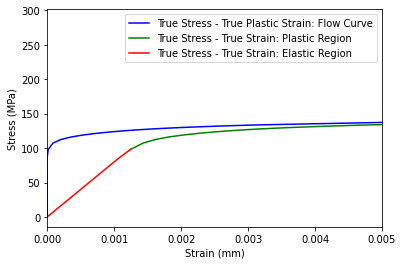

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9998518591863725


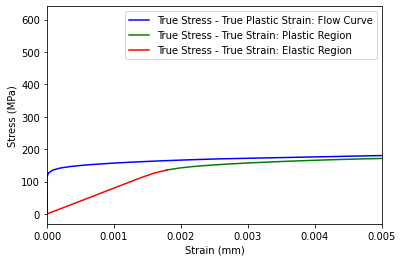

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9984044207910179


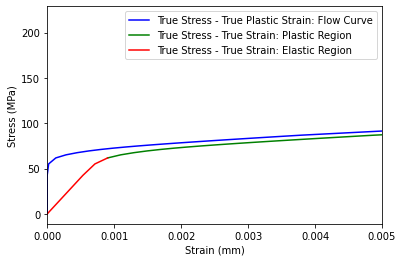

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9835458850601242


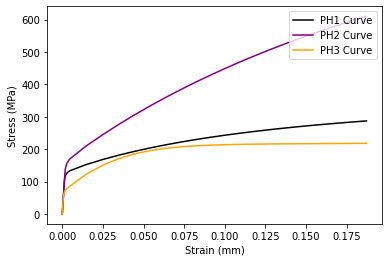

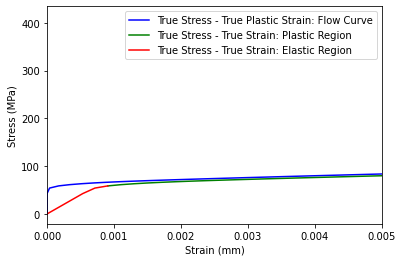

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9699768940094319


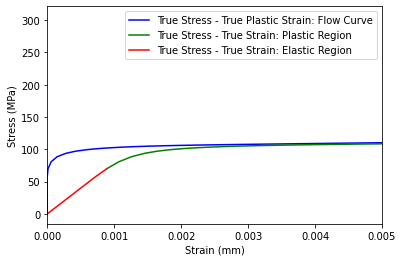

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9998179588739566


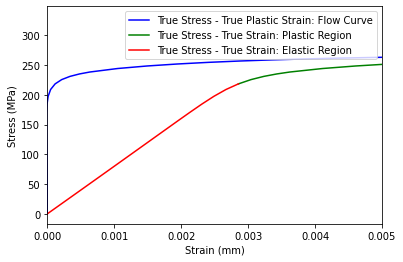

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9990117166262248


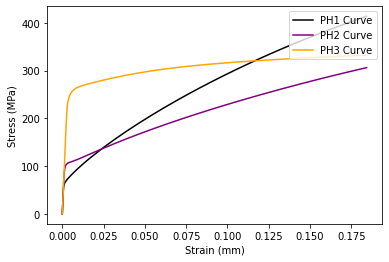

In [4]:
material = "RVE_1_40_D"
CPLaw = "PH"
trueStressStrain = []
trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('G:H', CPLaw, material, True, 1)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('L:M', CPLaw, material, True, 2)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('Q:R', CPLaw, material, True, 3)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)
plot3curves(*trueStressStrain)

material = "RVE_1_40_D"
CPLaw = "DB"
trueStressStrain = []
trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('J:K', CPLaw, material, True, 1)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('P:Q', CPLaw, material, True, 2)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('V:W', CPLaw, material, True, 3)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)
plot3curves(*trueStressStrain)


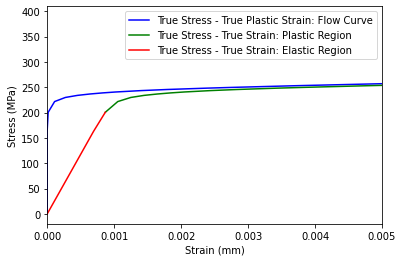

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9997230100716777


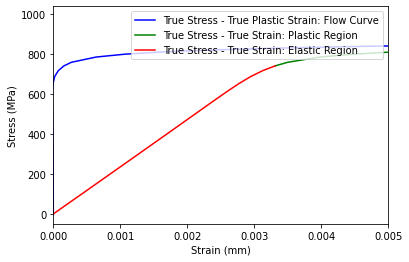

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9986852214203632


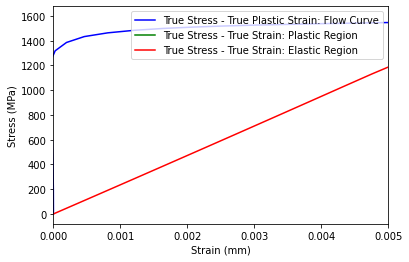

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9993169655372858


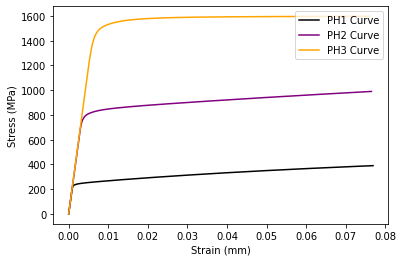

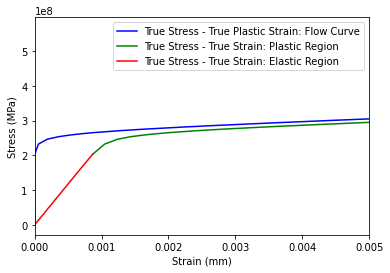

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9999859872034241


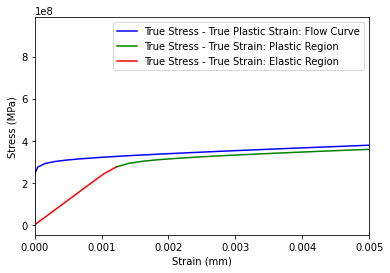

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.9987315868423592


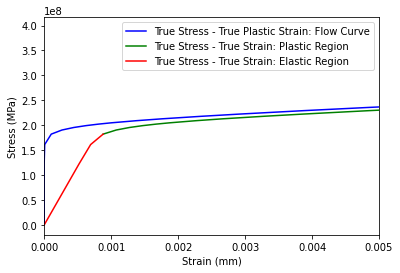

<Figure size 720x720 with 0 Axes>

Adjusted R squared =  0.987155969788108


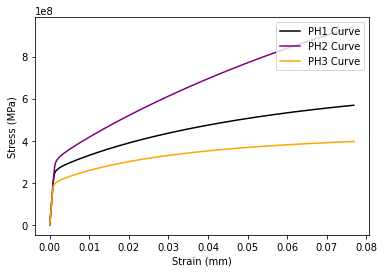

In [5]:
material = "512grains512"
CPLaw = "PH"
trueStressStrain = []
trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('G:H', CPLaw, material, True, 1)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('N:O', CPLaw, material, True, 2)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('T:U', CPLaw, material, True, 3)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)
plot3curves(*trueStressStrain)

material = "512grains512"
CPLaw = "DB"
trueStressStrain = []
trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('G:H', CPLaw, material, True, 1)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('M:N', CPLaw, material, True, 2)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)

trueStress, trueStrain, truePlasticStrain = preprocessExperimentalCurve('S:T', CPLaw, material, True, 3)
trueStressStrain.extend([trueStress, trueStrain])
elasticStress, elasticStrain, trimmedStress, trimmedStrain, r2 = elastic(trueStress, trueStrain, truePlasticStrain)
plot(elasticStress, elasticStrain, trimmedStress, trimmedStrain, trueStress, truePlasticStrain, r2)
plot3curves(*trueStressStrain)